<a href="https://colab.research.google.com/github/rafisondi/ml-playground/blob/main/GaussianProcess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

{'k1': 1**2, 'k2': RBF(length_scale=1), 'k1__constant_value': 1.0, 'k1__constant_value_bounds': (1e-05, 100000.0), 'k2__length_scale': 1.0, 'k2__length_scale_bounds': (1e-05, 100000.0)}


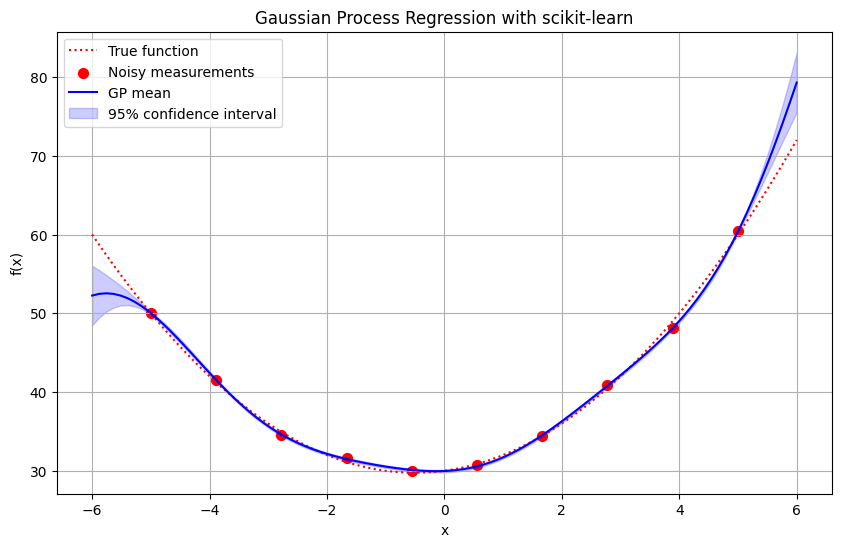

In [363]:


# Define the function we want to approximate
def function(x):
    return 1 * x + x ** 2 + 30

# Create noisy observations
def noisy_function(x, noise_var):
    return function(x) + np.random.normal(0, np.sqrt(noise_var), len(x))

# Generate some training data
x_measurement = np.linspace(-5, 5, 10).reshape(-1, 1)
y_values = noisy_function(x_measurement.flatten(), noise_var=0.5)

# Define the kernel: RBF with a constant term for scaling
kernel = C(1.0) * RBF(length_scale=1.0)

# Create and fit the Gaussian Process regressor
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1**2,)  # alpha is the noise variance
gp.fit(x_measurement, y_values)

# Generate inference points
x_inference = np.linspace(-6, 6, 100).reshape(-1, 1)

# Make predictions (mean and standard deviation)
y_pred, sigma = gp.predict(x_inference, return_std=True)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(x_inference, function(x_inference), 'r:', label="True function")
plt.scatter(x_measurement, y_values, c='r', s=50, label='Noisy measurements')
plt.plot(x_inference, y_pred, 'b-', label='GP mean')
plt.fill_between(
    x_inference.flatten(),
    y_pred - 1.96 * sigma,
    y_pred + 1.96 * sigma,
    alpha=0.2,
    color='blue',
    label='95% confidence interval'
)
print(kernel.get_params())
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Gaussian Process Regression with scikit-learn')
plt.legend()
plt.grid()
plt.show()


In [364]:
def function(x):
    return np.sin(x)

def noisy_measurement(x, noise_var):
    return function(x) + np.random.normal(0, noise_var , len(x))

def corr_function(x):
    return np.array([1, x, x**2, x**3], dtype="object")

def exponential_cov(x, y, params):
    return params[0] * np.exp( -0.5 * params[1] * np.subtract.outer(x, y)**2)

def exp_sine_squared_kernel(x1, x2, length_scale=1.0, periodicity=1.0):
    x1 = x1[:, np.newaxis]  # Shape (n_samples1, 1)
    x2 = x2[np.newaxis, :]  # Shape (1, n_samples2)

    dists = np.abs(x1 - x2)  # Shape (n_samples1, n_samples2)
    kernel_matrix = np.exp(-2 * (np.sin(np.pi / periodicity * dists) ** 2) / (length_scale ** 2))

    return kernel_matrix

def linear_kernel(x1, x2):
    return exponential_cov(x1, x2 , [1 , 1] )

def prior_mean_function(x):
    return np.zeros_like(x)

def k_column(x, x_values):
    return np.array([linear_kernel(x, x_val) for x_val in x_values])



def GaussianProcess(x_inference, x_measurement, y_values, var):

  length=1.34
  periodicity=6.57

  jitter = 1e-6
  mu = prior_mean_function(x_inference)
  mu_prior = prior_mean_function(x_measurement)

  K_matrix = exp_sine_squared_kernel(x_measurement, x_measurement , length, periodicity)
  K_inference = exp_sine_squared_kernel(x_inference, x_inference , length, periodicity)
  k_xA = exp_sine_squared_kernel(x_inference, x_measurement , length, periodicity)


  mu = k_xA @ np.linalg.inv(K_matrix + var * np.identity(K_matrix.shape[0])) @ (y_values - mu_prior) + mu
  sigma = K_inference - k_xA @ np.linalg.inv(K_matrix+ var * np.identity(K_matrix.shape[0])) @ k_xA.T

  return mu, sigma


In [365]:
# Data points
x = np.linspace(0, 5 , 1000)
x_measurement = np.linspace(1, 4 , 20) # np.sort(np.random.uniform(0.0,20,10)) #x[::5]
noise_var = 0.0

# Functions
f_values = function(x)
f_sampled = function(x_measurement)
y_values = noisy_measurement(x_measurement, noise_var)

# Inference
x_inference = np.array(np.linspace(0,5,1000))
intial_model_inference = prior_mean_function(x_inference)

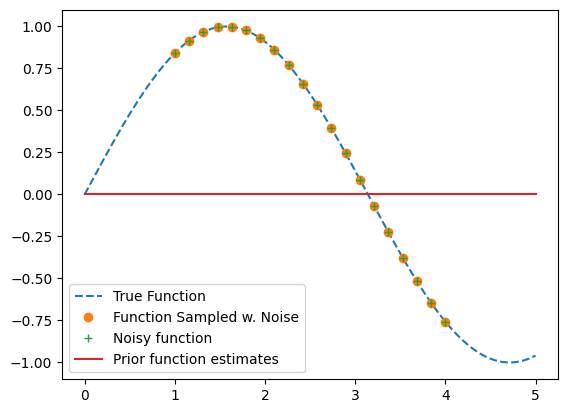

In [366]:
plt.figure()
plt.plot(x,f_values , '--' , label = "True Function")
plt.plot(x_measurement, f_sampled, 'o' , label = "Function Sampled w. Noise")
plt.plot(x_measurement, y_values, '+', label = 'Noisy function')
plt.plot(x_inference, intial_model_inference, '-' , label = 'Prior function estimates')
plt.legend()
plt.show()

In [367]:
# Gaussian process
# mu_new, K_matrix_new = GaussianProcess(x_inference, x_measurement, y_values, noise_var)
mu_new, K_matrix_new = GaussianProcess(x_inference, x_measurement, f_sampled, noise_var)
variance_diag = np.diag(K_matrix_new)
std_dev = np.sqrt(variance_diag)
confidence_interval = 1.96 * std_dev


<ipython-input-367-f3a9f9000370>:5: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(variance_diag)


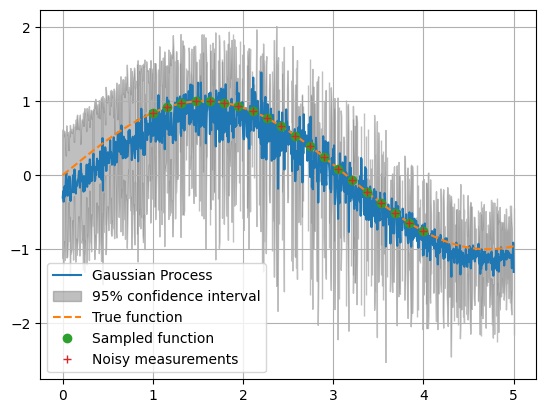

In [368]:
plt.figure()

plt.plot(x_inference, mu_new, label='Gaussian Process')
plt.fill_between(x_inference,
                 (mu_new - confidence_interval),
                 (mu_new + confidence_interval),
                 color='gray', alpha=0.5, label='95% confidence interval')

plt.plot(x, f_values, '--', label='True function')
plt.plot(x_measurement, f_sampled, 'o', label='Sampled function')
plt.plot(x_measurement, y_values, '+', label='Noisy measurements')
plt.legend()
plt.grid()
plt.show()